0) Librairies and "Plot" Function

In [2]:
import pylab as pl
import openturns as ot
import openturns.viewer as otv
from openturns.usecases import flood_model

from matplotlib import pylab as plt
import numpy as np
import scipy.stats as scs 

In [3]:
def plotXvsY(sampleX, sampleY, figsize = (15, 3)):
    
    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = pl.figure(figsize = figsize)
    
    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i + 1)
        graph = ot.Graph("", inputdescr[i], "Y", True, "")
        cloud = ot.Cloud(sampleX[:, i], sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    
    return(fig)

In [4]:
def plotHist(sampleX, sampleY, figsize = (15, 3)):
    
    dimX = sampleX.getDimension() 
    dimY = sampleY.getDimension()
    dim = dimX + dimY
    inputdescrX = sampleX.getDescription()
    inputdescrY = sampleY.getDescription()
    fig = pl.figure(figsize = figsize)
    
    for i in range(dim):
        if i < dimX:
            ax = fig.add_subplot(1, dim, i + 1)
            graph = ot.Graph("", inputdescrX[i], "", True, "")
            hist = ot.HistogramFactory().build(sampleX[:, i]).drawPDF()
            graph.add(hist)
            _ = ot.viewer.View(graph, figure=fig, axes=[ax])
        else :
            ax = fig.add_subplot(1, dim, i + 1)
            graph = ot.Graph("", inputdescrY[dimX - i], "", True, "")
            hist = ot.HistogramFactory().build(sampleY[:, dimX - i]).drawPDF()
            graph.add(hist)
            _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    
    return(fig)

1) Sampling Functions

In [5]:
def sampling(X, n_sample, method = 'lhs', 
             space_filling = 'C2', T0 = 10, c = 0.95, iMax = 2000, 
             plot = True, fig_size = 15):

    distribution = ot.ComposedDistribution(X)
    dim = distribution.getDimension()
    bounds = distribution.getRange()

    if method == 'mc':
        sampleX = distribution.getSample(n_sample)
        
    elif method == 'sobol':
        N = round(np.log(n_sample)/np.log(2),0)
        sequence = ot.SobolSequence(dim)
        sobol = ot.LowDiscrepancyExperiment(sequence, distribution, 2**N, False)
        sampleX = sobol.generate(dim, n_sample)

    elif method == 'lhs':
        lhs = ot.LHSExperiment(distribution, n_sample, False, False)
        sampleX = lhs.generate()
        
    elif method == 'lhs_opti':
        lhs_opti = ot.LHSExperiment(distribution, n_sample)
        lhs_opti.setAlwaysShuffle(True)  # randomized
        
        if space_filling == 'C2':
            # C2
            space_filling = ot.SpaceFillingC2()
        elif space_filling == 'PhiP':
            # PhiP with default p
            space_filling = ot.SpaceFillingPhiP()
        elif space_filling == 'mindist':
            # mindist
            space_filling = ot.SpaceFillingMinDist()
        else :
            # C2
            space_filling = ot.SpaceFillingC2()
        
        # T0=10, c=0.95, iMax=2000
        temperatureProfile = ot.GeometricProfile(T0, c, iMax)
        algo = ot.SimulatedAnnealingLHS(lhs_opti, space_filling, temperatureProfile)
        sampleX = algo.generate()
        
    else:
        lhs = ot.LHSExperiment(distribution, n_sample, False, False)
        sampleX = lhs.generate()
        print('Pick a method in [mc, sobol, lhs, lhs_opti]. lhs by default')
    
    if plot :
        fig = otv.PlotDesign(sampleX, bounds)
        fig.set_size_inches(fig_size, fig_size)
        plt.show()
    
    return(sampleX)

2) Inputs + Model (Fluage Eurocode)

In [6]:
# INPUT

# Observation eurocode

dim_eurocode = 4
input_eurocode = ["uRh", "bfcm", "bt0", "t"]
fluage_eurocode = ot.SymbolicFunction(
    input_eurocode, ["uRh*bfcm*bt0*((t-28)/(477.90+t-28))"]
)

mean_uRH, mean_bfcm, mean_bt0 = 0.451869, 2.7619, 0.48845
std_uRH, std_bfcm, std_bt0 = 0.15, 0.7, 0.15

X_eurocode = [ot.Normal(mean_uRH, std_uRH), 
     ot.Normal(mean_bfcm, std_bfcm), 
     ot.Normal(mean_bt0, std_bt0), 
     ot.Uniform(0, 200)]

distribution = ot.ComposedDistribution(X_eurocode)
distribution.setDescription(input_eurocode)

In [7]:
# Observation monitoring

dim_monitoring = 2
input_monitoring = ["ecct", "Ecrc"]
fluage_monitoring = ot.SymbolicFunction(
    input_monitoring, ["ecct*Ecrc"]
)

Ecrc_R_mean = [111.99, 116.73, 116.73, 67.93, 64.93, 45.43, 45.43, 69.20, 69.20, 107.92]
Ecrc_R_cov = 0.2

Ecrc_R_mean = [80.57, 43.19, 43.19, 49.81, 49.81, 6.43, 6.43, 41.70, 41.70, 109.35]
Ecrc_R_cov = 0.2

X_monitoring = [ot.Normal(mean_uRH, std_uRH), 
     ot.Normal(mean_bfcm, std_bfcm), 
     ot.Normal(mean_bt0, std_bt0), 
     ot.Uniform(0, 200)]

distribution = ot.ComposedDistribution(X_monitoring)
#distribution.setDescription(input_eurocode)

3) Monte Carlo Sampling

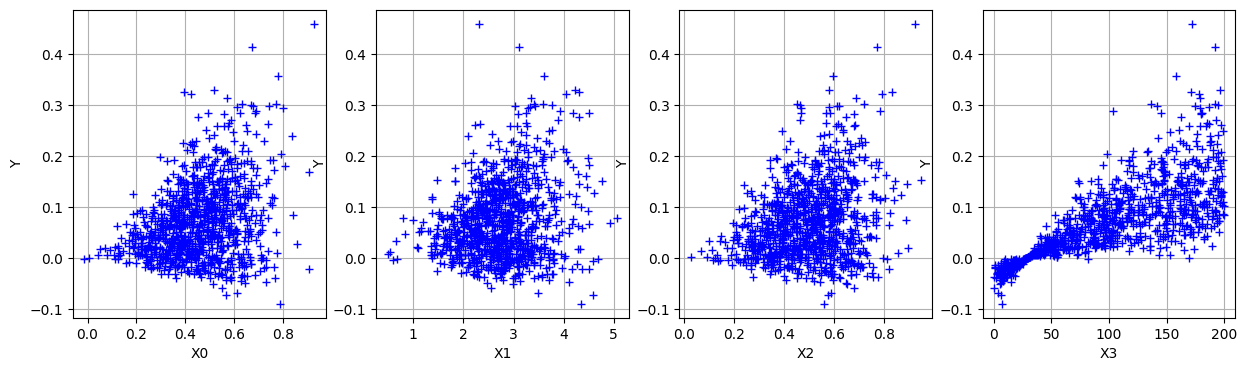

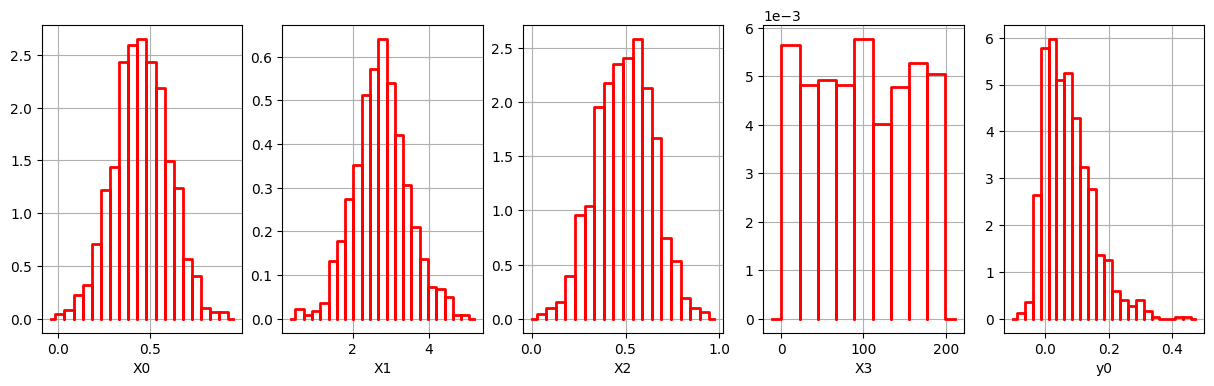

In [8]:
# MONTE CARLO (Brute Force) - 'mc'

method = 'mc'
n_sample = 1000

sampleX = sampling(X_eurocode, n_sample, method = method, plot = False)
sampleY = fluage_eurocode(sampleX)

fig = plotXvsY(sampleX, sampleY, figsize=(15, 4))
pl.show()

fig = plotHist(sampleX, sampleY, figsize = (15, 4))
pl.show()

4) Latin Hypercube Sampling

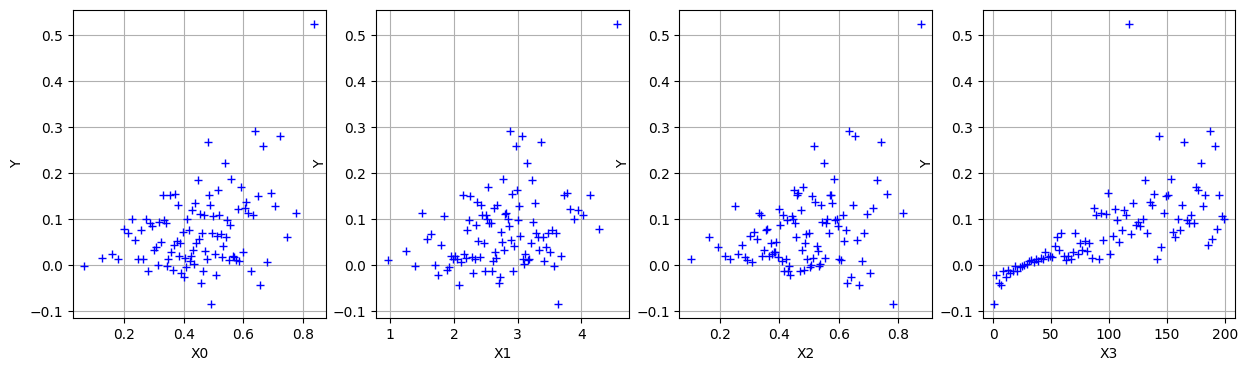

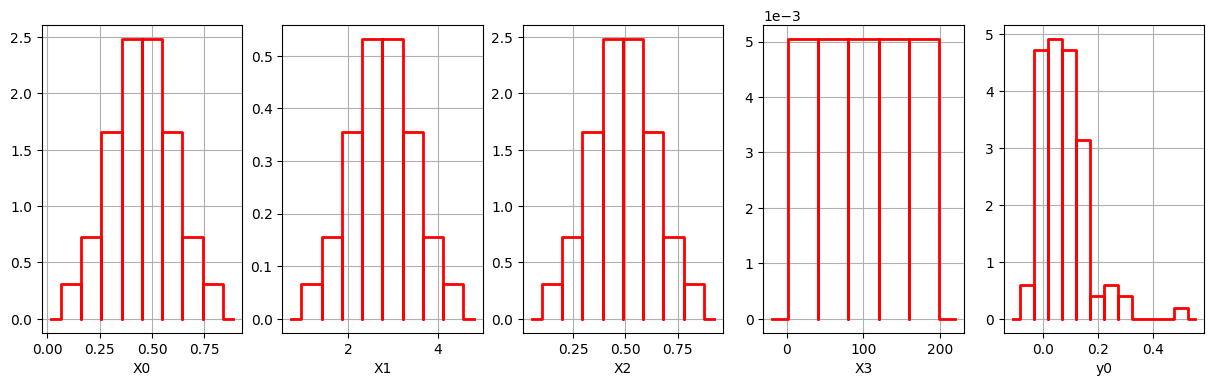

In [13]:
# LATIN HYPERCUBE SAMPLING - 'lhs'

method = 'lhs'
n_sample = 100

sampleX = sampling(X_eurocode, n_sample, method = method, plot = False)
sampleY = fluage_eurocode(sampleX)

fig = plotXvsY(sampleX, sampleY, figsize=(15, 4))
pl.show()

fig = plotHist(sampleX, sampleY, figsize = (15, 4))
pl.show()

4) Latin Hypercube Opti Sampling

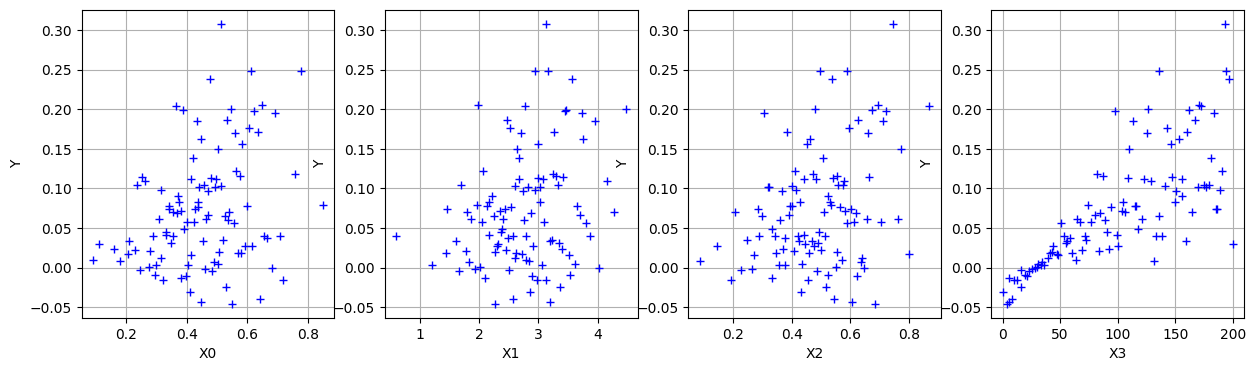

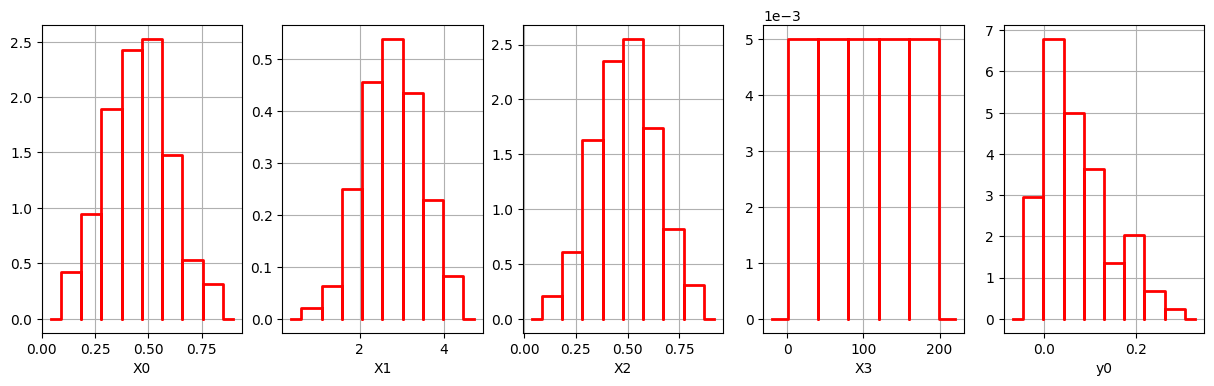

In [14]:
# LHS opti hyperparameters

method = 'lhs_opti'
n_sample = 100

space_filling = 'C2'
T0 = 10
c = 0.95
iMax = 2000

sampleX = sampling(X_eurocode, n_sample, method = method, plot = False)
sampleY = fluage_eurocode(sampleX)

fig = plotXvsY(sampleX, sampleY, figsize=(15, 4))
pl.show()

fig = plotHist(sampleX, sampleY, figsize = (15, 4))
pl.show()